In [1]:
import dill
import struct
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from my.net import *

In [2]:
# 用于适配interview接口
class MNIST_Net(Net):
    @staticmethod
    def image_data(file_name):
        with open(file_name, "rb") as f:
            buffer = f.read(16)
            magic, num, rows, cols = struct.unpack(">iiii", buffer)
            buffer = f.read(rows * cols * num)
            data = np.frombuffer(buffer, dtype=np.uint8)
            data = data.reshape(num, rows, cols)
        return data

    @staticmethod
    def label_data(file_name):
        with open(file_name, "rb") as f:
            buffer = f.read(8)
            magic, num = struct.unpack(">ii", buffer)
            buffer = f.read(num)
            data = np.frombuffer(buffer, dtype=np.uint8)
            data = data.reshape(num, 1)
        return data

    @staticmethod
    def one_hot(labels, num_classes):
        one_hot_labels = np.zeros((len(labels), num_classes))
        for i in range(len(labels)):
            one_hot_labels[i, labels[i]] = 1
        return one_hot_labels

    def interview(self, eval_datafile_path):
        eval_images = self.image_data(eval_datafile_path[0])
        eval_labels = self.label_data(eval_datafile_path[1])
        eval_labels = self.one_hot(eval_labels, 10)
        _eval_labels = self.pred(eval_images)
        return np.mean(np.argmax(eval_labels, axis=1) == np.argmax(_eval_labels, axis=1)) * 100

(60000, 28, 28) (60000, 1)


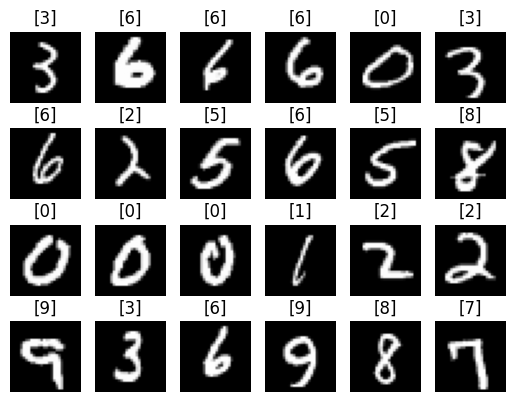

In [3]:
# 读取文件数据
images = MNIST_Net.image_data("/opt/data/mnist_testdata/train-images.idx3-ubyte")
labels = MNIST_Net.label_data("/opt/data/mnist_testdata/train-labels.idx1-ubyte")
print(images.shape, labels.shape)

# 随机打乱数据
np.random.seed(0)
indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(labels[i])
    plt.axis("off")
plt.show()

In [4]:
# 分割训练集与验证集 (4:1)
split = int(len(images) * 0.8)
train_images, valid_images = images[:split], images[split:]
train_labels, valid_labels = labels[:split], labels[split:]

In [5]:
# 添加图片通道
height, width = images.shape[1], images.shape[2]
train_images = train_images.reshape(train_images.shape[0], 1, height, width)
valid_images = valid_images.reshape(valid_images.shape[0], 1, height, width)

# 独热标签数据
train_labels = MNIST_Net.one_hot(train_labels, 10)
valid_labels = MNIST_Net.one_hot(valid_labels, 10)

print(train_images.shape, valid_images.shape)
print(train_labels.shape, valid_labels.shape)

(48000, 1, 28, 28) (12000, 1, 28, 28)
(48000, 10) (12000, 10)


In [6]:
def shuffle_data(images, labels):
    np.random.seed(0)
    indices = np.random.permutation(len(images))
    return images[indices], labels[indices]

In [7]:
# 97.89%
net_info = [
    {"module": Flatten},
    {"module": Mlp, "param": {"in_features": 784, "out_features": 256}},
    {"module": Gelu},
    {"module": Dropout, "param": {"p": 0.3}},
    {"module": Mlp, "param": {"in_features": 256, "out_features": 64}},
    {"module": Gelu},
    {"module": Dropout, "param": {"p": 0.3}},
    {"module": Mlp, "param": {"in_features": 64, "out_features": 16}},
    {"module": Gelu},
    {"module": Dropout, "param": {"p": 0.3}},
    {"module": Mlp, "param": {"in_features": 16, "out_features": 10}},
    {"module": Softmax},
]

net = MNIST_Net(net_info, 2)

In [8]:
record = [] # 记录训练过程
epoch_count = 0  # 总训练轮数
best_accuracy = 0  # 最佳准确率
model_path = "task1-mnist.pkl"  # 模型保存路径

batch_size = 512  # 批量大小

initial_lr = 10  # 初始学习率
lr_count = 0  # 连续无增长计数
lr_patience = 10  # 学习率容忍次数
lr_factor = 0.5  # 学习率衰减因子

worse_count = 0  # 连续无增长计数
worse_tolerance = 20  # 无增长容忍次数

In [9]:
max_epochs = 200
pbar = tqdm(range(max_epochs))
for i in pbar:
    train_images, train_labels = shuffle_data(train_images, train_labels)
    net.train(train_images, train_labels, CrossEntropy, batch_size, initial_lr)

    _train_labels = net.pred(train_images)
    _valid_labels = net.pred(valid_images)
    _train_loss = CrossEntropy.forward(train_labels, _train_labels)
    _valid_loss = CrossEntropy.forward(valid_labels, _valid_labels)
    _valid_accuracy = np.mean(np.argmax(_valid_labels, axis=1) == np.argmax(valid_labels, axis=1)) * 100

    epoch_count += 1
    if _valid_accuracy > best_accuracy:
        lr_count, worse_count = 0, 0
        best_accuracy = _valid_accuracy
        with open(model_path, "wb") as f:
            dill.dump(net, f)
    else:
        lr_count += 1
        worse_count += 1
        if lr_count > lr_patience:
            initial_lr *= lr_factor
            lr_count = 0
        if worse_count > worse_tolerance:
            print(f"模型连续{worse_tolerance}次无提升，提前终止训练")
            break

    pbar.set_postfix(train_loss=_train_loss, valid_loss=_valid_loss, accuracy=f"{_valid_accuracy:.2f}%", best_accuracy=f"{best_accuracy:.2f}%", lr=initial_lr)
    record.append([_train_loss, _valid_loss, _valid_accuracy])

print("模型架构:", net)
print("保存路径:", model_path)
print("最佳训练轮数:", epoch_count - worse_tolerance)
print("最佳准确率:", best_accuracy)

 74%|███████▍  | 149/200 [09:30<03:15,  3.83s/it, accuracy=97.84%, best_accuracy=97.93%, lr=1.25, train_loss=0.0184, valid_loss=0.092] 

模型连续20次无提升，提前终止训练
模型架构: Net(
  (0): Flatten()
  (1): Mlp(in_features=784, out_features=256)
  (2): Gelu()
  (3): Dropout(p=0.3)
  (4): Mlp(in_features=256, out_features=64)
  (5): Gelu()
  (6): Dropout(p=0.3)
  (7): Mlp(in_features=64, out_features=16)
  (8): Gelu()
  (9): Dropout(p=0.3)
  (10): Mlp(in_features=16, out_features=10)
  (11): Softmax()
)
保存路径: task1-mnist.pkl
最佳训练轮数: 130
最佳准确率: 97.93333333333332


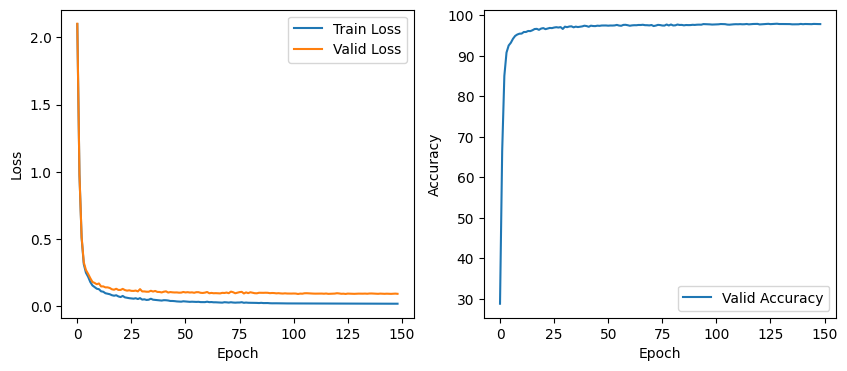

In [10]:
# 绘制训练曲线
# 图1: 训练损失与验证损失
# 图2: 验证准确率
record = np.array(record)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(record[:, 0], label="Train Loss")
plt.plot(record[:, 1], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(record[:, 2], label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


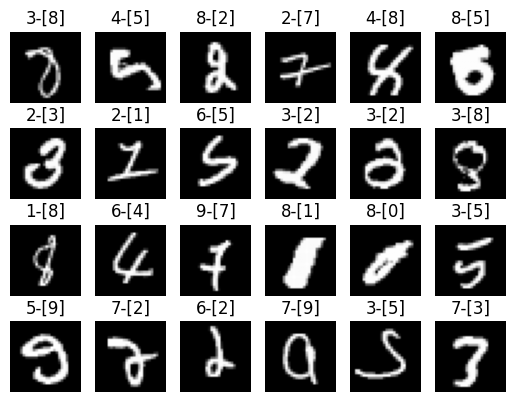

In [11]:
# 打印识别失败的图片
_valid_labels = net.pred(valid_images)
indices = np.argmax(_valid_labels, axis=1) != np.argmax(valid_labels, axis=1)
indices = np.random.permutation(np.where(indices)[0])


# 标题为 (预测-准确)
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(valid_images[indices][i].reshape(28, 28), cmap="gray")
    plt.title(f"{np.argmax(_valid_labels[indices][i])}-[{np.argmax(valid_labels[indices][i])}]")
    plt.axis("off")
plt.show()